# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Оглавление:

1. [Подготовка данных](#chapter1)<br>
2. [Исследование задачи](#chapter2)<br>
3. [Борьба с дисбалансом](#chapter3)<br>
4. [Тестирование модели](#chapter4)<br>

# 1. Подготовка данных
<a class="anchor" id="chapter1"></a>

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

In [7]:
data = pd.read_csv('datasets/Churn.csv')

In [8]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Признаки
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — количество недвижимости у клиента
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата<br>

Целевой признак
- Exited — факт ухода клиента

Мы видим ненужные нам столбцы не имеющие логики связи с отоком клиентов, такие как - номер строки, ID клиента и фамилия, уберем их

In [10]:
data['Exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

 Мы видим что по факту уходит 20% клиентов

In [11]:
data = data.drop(['CustomerId', 'RowNumber', 'Surname'], axis=1)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


Мы видим пропуски в столбце Tenure - количество недвижимости, полагаем там где пропуски клиент не владеет недвижимостью и решил скрыть информацию либо просто ее не указывать, заменим пропуски на нули, да и слишком низкиий процент клиентов без недвижимости для нашей выборки, менее 4%, очень это странно, либо у нас особые клиенты которые почти все владеют недвижимостью, что не указывалось в задаче.

In [13]:
data['Tenure'].value_counts()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: Tenure, dtype: int64

In [14]:
data['Tenure']=data['Tenure'].fillna(0)

Проверим итоги

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


In [16]:
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [17]:
data.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,4.543400,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,3.111573,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,4.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Сделаем кодирование категориальных признаков методом one_hot_encording подходящим для разных видов ML, и поделим данные на тренировочную, валидационную и тестовую выборки

In [18]:
data_ohe = pd.get_dummies(data, drop_first=True)
target = data_ohe['Exited']
features = data_ohe.drop('Exited', axis=1)
features_train, features_testing, target_train, target_testing = train_test_split(
    features, target, stratify=target, test_size=0.4, random_state=12345)
features_test, features_valid, target_test, target_valid = train_test_split(
    features_testing, target_testing, stratify=target_testing, test_size=0.5, random_state=12345)

Сохраним ввиде новых объектов наши выборки

In [19]:
features_train = features_train.copy()
features_valid = features_valid.copy()
features_test = features_test.copy()
target_train = target_train.copy()
target_valid = target_valid.copy()
target_test = target_test.copy()

In [20]:
features.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,4.543400,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.250900,0.247700,0.545700
std,96.653299,10.487806,3.111573,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.433553,0.431698,0.497932
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000,0.000000,0.000000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000,0.000000,0.000000
50%,652.000000,37.000000,4.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000,0.000000,1.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,1.000000,0.000000,1.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000,1.000000,1.000000


Теперь масштабируем численные признаки

In [21]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [22]:
scaler = StandardScaler()
scaler.fit(features_train.loc[:, numeric])
features_train.loc[:, numeric] = scaler.transform(features_train.loc[:, numeric])
features_valid.loc[:, numeric] = scaler.transform(features_valid.loc[:, numeric])
features_test.loc[:, numeric] = scaler.transform(features_test.loc[:, numeric])

In [23]:
features_train.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
count,6.000000e+03,6.000000e+03,6.000000e+03,6.000000e+03,6.000000e+03,6000.000000,6000.000000,6.000000e+03,6000.000000,6000.00000,6000.000000
mean,5.765758e-16,5.192143e-17,-1.648357e-16,-1.318205e-16,1.153337e-16,0.699500,0.515500,-9.272907e-17,0.248500,0.24900,0.548500
std,1.000083e+00,1.000083e+00,1.000083e+00,1.000083e+00,1.000083e+00,0.458514,0.499801,1.000083e+00,0.432179,0.43247,0.497684
min,-3.091423e+00,-2.001708e+00,-1.461501e+00,-1.219673e+00,-9.147077e-01,0.000000,0.000000,-1.743588e+00,0.000000,0.00000,0.000000
25%,-6.900136e-01,-6.671831e-01,-8.185176e-01,-1.219673e+00,-9.147077e-01,0.000000,0.000000,-8.612047e-01,0.000000,0.00000,0.000000
50%,1.082696e-02,-1.905670e-01,-1.755344e-01,3.352877e-01,-9.147077e-01,1.000000,1.000000,-3.425867e-04,0.000000,0.00000,1.000000
75%,6.910545e-01,4.766956e-01,7.889404e-01,8.252858e-01,8.209806e-01,1.000000,1.000000,8.659700e-01,0.000000,0.00000,1.000000
max,2.061816e+00,5.052210e+00,1.753415e+00,2.588919e+00,4.292357e+00,1.000000,1.000000,1.730631e+00,1.000000,1.00000,1.000000


### Вывод

- Мы убрали из данных не информативные для нас столбцы с номером строки, номером ID, фамилией клиента,
- Обработали пропуски в столбце Tenure - количество недвижимости,
- Сделали кодирование категориальных признаков методом one_hot_encording подходящим для разных видов ML, 
- Поделили данные на тренировочную, валидационную и тестовую выборки,
- Сделали масштабирование численных признаков.<br>

Данные предобработаны, закодированы, масштабированы и поделены на выборки. Теперь можно обучать ML модель и исследовать задачу.

# 2. Исследование задачи
<a class="anchor" id="chapter2"></a>

#### Исследуем модель с логистической регрессией

In [24]:
model = LogisticRegression(random_state=12345, solver='liblinear') 
# инициализируем модель логистической регрессии
model.fit(features_train, target_train) 
# обучим модель на тренировочной выборке
accuracy = model.score(features_valid, target_valid) 
# получим метрику качества модели на валидационной выборке
predicted_valid = model.predict(features_valid)
#сделаем предикт для проверки метрики F1
f1 = f1_score(target_valid, predicted_valid)

# сохряняю метрики в глобальные переменные
acuracy_logreg_nobalance = accuracy
f1_logreg_nobalance = f1

print("Accuracy модели логистической регрессии на валидационной выборке:", accuracy)
print("F1 score модели логистической регрессии на валидационной выборке:", f1)

Accuracy модели логистической регрессии на валидационной выборке: 0.812
F1 score модели логистической регрессии на валидационной выборке: 0.2932330827067669


Теперь проверим модель на адекватность, задав везде исход с наибольшим весом по целевым признакам - 0

In [25]:
target_pred_constant = pd.Series( 0, index=target_valid.index)
print(accuracy_score(target_valid, target_pred_constant))

0.7965


Наша модель практически не имеет разницы в точности предсказаний с рандомной моделью по наибольшему целевому признаку, это не радует =/

#### Исследуем модель с лесом решений

Попробуем с акцентировать на метрике F1_score и перебрать лес деревьев, а по модели наибольшей F1_score взять accurancy и сделать проверку на адекватность

In [26]:
%%time

best_model = None
best_accuracy = 0
best_est = 0
best_depth = 0
best_f1_score = 0

for est in range(10, 51, 5): # создаем цикл перебирая с 10 по 50 деревьев в лесу с шагом 5
    for depth in range (1, 21): # внутри цикла еще один цикл перебирающий глубину деревьев от 1 до 20
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth) 
        # создаем пустую модель с заданным количеством деревьев
        model.fit(features_train, target_train)
        # считаем модель на тренировочной выборке
        accuracy = model.score(features_valid, target_valid) 
        # считаем качество модели на валидационной выборке
        predicted_valid = model.predict(features_valid)
        #сделаем предикт для проверки метрики F1
        f1 = f1_score(target_valid, predicted_valid)
        # считаем f1_score модели на валидационной выборке
        if f1 > best_f1_score:
            best_model = model
            # сохраняем наилучшую модель
            best_accuracy = accuracy
            #  сохраняем наилучшее значение метрики accuracy на валидационных данных
            best_est = est
            # сохраняем наилучшее значение с количеством деревьев
            best_depth = depth
            # сохраняем наилучшее значние с глубиной дерева
            best_f1_score = f1

# сохряняю метрики в глобальные переменные
acuracy_forest_nobalance = best_accuracy
f1_forest_nobalance = best_f1_score

print("Accuracy по наилучшей f1_score модели на валидационной выборке:", best_accuracy)
print("Количество деревьев:", best_est)
print("Оптимальная глубина дерева:", best_depth)
print("Лучшая F1_score:", best_f1_score)

/Users/daniilsinitsin/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/daniilsinitsin/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/daniilsinitsin/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/daniilsinitsin/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/d

Accuracy по наилучшей f1_score модели на валидационной выборке: 0.855
Количество деревьев: 45
Оптимальная глубина дерева: 18
Лучшая F1_score: 0.5606060606060606
CPU times: user 35.3 s, sys: 706 ms, total: 36 s
Wall time: 37.8 s


Теперь проверим модель на адекватность, задав везде исход с наибольшим весом по целевым признакам - 0

In [27]:
target_pred_constant = pd.Series( 0, index=target_valid.index)
accuracy_const = accuracy_score(target_valid, target_pred_constant)
f1_const = 0.59
print(accuracy_const)

0.7965


Данная модель проходит тест на адекватность по accuracy(0,85 > 0,79), но не проходит проверку f1_score (0.56 < 0,59)

In [28]:
print('Название                                           | Accuracy | F1_score |')
print('------------------------------------------------------------------------')
print('Константная модель                                     {: <8.3f}   {: <8.3f} '.format(accuracy_const, f1_const))
print('Модель логической регрессии, несбалансированной             {: <8.3f}   {: <8.3f} '.format(acuracy_logreg_nobalance, f1_logreg_nobalance))
print('Модель дерева решений ,несбалансированная                  {: <8.3f}   {: <8.3f} '.format(acuracy_forest_nobalance, f1_forest_nobalance))

Название                                           | Accuracy | F1_score |
------------------------------------------------------------------------
Константная модель                                     0.796      0.590    
Модель логической регрессии, несбалансированной             0.812      0.293    
Модель дерева решений ,несбалансированная                  0.855      0.561    


В конце посмотрим какой дисбаланс у нас по классам в данных

In [29]:
data['Exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

Здесь мы видим дисбаланс классов 80 на 20

### Вывод
Мы видим, что лес решений дает нам результат уже лучше чем линейная регрессия, но он все еще недостаточно хорош и его можно еще улучшить, если нам получиться побороть дисбаланс классов который мы видим в признаках.

# 3. Борьба с дисбалансом
<a class="anchor" id="chapter3"></a>

Теперь попробуем при обучении скорректировать балансы классов и посмотрим на результаты обучения (0 - 80%, 1 - 20%)

#### Подбор гиперпараметров с изменением весса редкого класса. 
Добавим в нашу модель аргументы, class_weight='balanced'. Редкий клас будет иметь теперь больший вес.

In [30]:
%%time

best_model = None
best_accuracy = 0
best_est = 0
best_depth = 0
best_f1_score = 0

for est in range(10, 51, 5): # создаем цикл перебирая с 10 по 50 деревьев в лесу с шагом 5
    for depth in range (1, 21): # внутри цикла еще один цикл перебирающий глубину деревьев от 1 до 20
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth, class_weight='balanced') 
        # создаем пустую модель с заданным количеством деревьев
        model.fit(features_train, target_train)
        # считаем модель на тренировочной выборке
        accuracy = model.score(features_valid, target_valid) 
        # считаем качество модели на валидационной выборке
        predicted_valid = model.predict(features_valid)
        #сделаем предикт для проверки метрики F1
        f1 = f1_score(target_valid, predicted_valid)
        # считаем f1_score модели на валидационной выборке
        if f1 > best_f1_score:
            best_model = model
            # сохраняем наилучшую модель
            best_accuracy = accuracy
            #  сохраняем наилучшее значение метрики accuracy на валидационных данных
            best_est = est
            # сохраняем наилучшее значение с количеством деревьев
            best_depth = depth
            # сохраняем наилучшее значние с глубиной дерева
            best_f1_score = f1
            # сохраняем наилучший f1_score 
print("Accuracy по наилучшей f1_score модели на валидационной выборке:", best_accuracy)
print("Количество деревьев:", best_est)
print("Оптимальная глубина дерева:", best_depth)
print("Лучшая F1_score:", best_f1_score)

Accuracy по наилучшей f1_score модели на валидационной выборке: 0.8275
Количество деревьев: 45
Оптимальная глубина дерева: 8
Лучшая F1_score: 0.6101694915254238
CPU times: user 34.4 s, sys: 647 ms, total: 35.1 s
Wall time: 35.7 s


Данная модель проходит тест на адекватность по accuracy (0,8275 > 0,79) и проходит проверку f1_score (0.61 > 0,59)

Возьмем наш лес с наилучшими гиперпараметрами: 45 деревьев и 8 глубина дерева,попробуем подобрать наилучший порог положительного класса 1

In [31]:
%%time

best_accuracy = 0
best_f1_score = 0
best_threshold = 0

model = RandomForestClassifier(random_state=12345, n_estimators=45, max_depth=8,
                               class_weight='balanced') # создаем пустую модель с заданным количеством деревьев
model.fit(features_train, target_train) # обучаем модель
    
probabilities_valid = model.predict_proba(features_valid) # создадим таблицу вероятностей классов
probabilities_one_valid = probabilities_valid[:, 1] # выделим вероятности 1 класса

for threshold in np.arange(0.1, 0.9, 0.02): 
    predicted_valid = probabilities_one_valid > threshold 
        # переведем предикт в булев массив сравнив вероятности единицы и порог в цикле от 0.1 до 0.9 с шагом 0.02
    f1 = f1_score(target_valid, predicted_valid)
        # считаем модель на тренировочной выборке
    accuracy = accuracy_score(target_valid, predicted_valid) 
        # считаем качество модели на валидационной выборке
    if f1 > best_f1_score:
        best_accuracy = accuracy
            #  сохраняем наилучшее значение метрики accuracy на валидационных данных
        best_f1_score = f1
            # сохраняем наилучший f1_score 
        best_threshold = threshold
            # сохраняем наилучший порог
            
# сохряняю метрики в глобальные переменные
acuracy_forest_weighted= best_accuracy
f1_forest_weighted = best_f1_score

print("Наилучшие гипермараметры модели: Порог = {:.2f} | Accuracy = {:.3f}, F1_score = {:.3f}"
      .format(best_threshold, best_accuracy, best_f1_score)
)

Наилучшие гипермараметры модели: Порог = 0.50 | Accuracy = 0.828, F1_score = 0.610
CPU times: user 329 ms, sys: 6.37 ms, total: 335 ms
Wall time: 336 ms


Данная модель проходит тест на адекватность по accuracy (0,828 > 0,79) и проходит проверку f1_score (0.61 > 0,59). Порог изменений не требует.

#### Подбор киперпараметров с увеличением доли редкого класса - upsampling

Сначала пропишем функцию для увеличения количества редкого класса, потом применим ее с коэф 4 для изменения баланса с 1:4 до 1:1.

In [32]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

Применим нашу функцию

In [33]:
%%time

best_model = None
best_accuracy = 0
best_est = 0
best_depth = 0
best_f1_score = 0

features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, 4)

for est in range(10, 51, 5): # создаем цикл перебирая с 10 по 50 деревьев в лесу с шагом 5
    for depth in range (1, 21): # внутри цикла еще один цикл перебирающий глубину деревьев от 1 до 20
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth,) 
        # создаем пустую модель с заданным количеством деревьев
        model.fit(features_train_upsampled, target_train_upsampled)
        # считаем модель на тренировочной выборке
        accuracy = model.score(features_valid, target_valid) 
        # считаем качество модели на валидационной выборке
        predicted_valid = model.predict(features_valid)
        #сделаем предикт для проверки метрики F1
        f1 = f1_score(target_valid, predicted_valid)
        # считаем f1_score модели на валидационной выборке
        if f1 > best_f1_score:
            best_model = model
            # сохраняем наилучшую модель
            best_accuracy = accuracy
            #  сохраняем наилучшее значение метрики accuracy на валидационных данных
            best_est = est
            # сохраняем наилучшее значение с количеством деревьев
            best_depth = depth
            # сохраняем наилучшее значние с глубиной дерева
            best_f1_score = f1
            # сохраняем наилучший f1_score 

print("Accuracy по наилучшей f1_score модели на валидационной выборке:", best_accuracy)
print("Количество деревьев:", best_est)
print("Оптимальная глубина дерева:", best_depth)
print("Лучшая F1_score:", best_f1_score)

Accuracy по наилучшей f1_score модели на валидационной выборке: 0.824
Количество деревьев: 50
Оптимальная глубина дерева: 9
Лучшая F1_score: 0.616557734204793
CPU times: user 49.1 s, sys: 1.06 s, total: 50.2 s
Wall time: 55.1 s


Данная модель проходит тест на адекватность по accuracy (0,824 > 0,79) и проходит проверку f1_score (0.616 > 0,59)

Возьмем наш лес с наилучшими гиперпараметрами: 50 деревьев и 9 глубина дерева,попробуем подобрать наилучший порог положительного класса 1

In [34]:
%%time

best_accuracy = 0
best_f1_score = 0
best_threshold = 0

features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, 4)

model = RandomForestClassifier(random_state=12345, n_estimators=50, max_depth=9)
    # создаем пустую модель с заданным количеством деревьев
model.fit(features_train_upsampled, target_train_upsampled) # обучаем модель
    
probabilities_valid = model.predict_proba(features_valid) # создадим таблицу вероятностей классов
probabilities_one_valid = probabilities_valid[:, 1] # выделим вероятности 1 класса

for threshold in np.arange(0.1, 0.9, 0.02): 
    predicted_valid = probabilities_one_valid > threshold 
        # переведем предикт в булев массив сравнив вероятности единицы и порог в цикле от 0.1 до 0.9 с шагом 0.02
    f1 = f1_score(target_valid, predicted_valid)
        # считаем модель на тренировочной выборке
    accuracy = accuracy_score(target_valid, predicted_valid) 
        # считаем качество модели на валидационной выборке
    if f1 > best_f1_score:
        best_accuracy = accuracy
            #  сохраняем наилучшее значение метрики accuracy на валидационных данных
        best_f1_score = f1
            # сохраняем наилучший f1_score 
        best_threshold = threshold
            # сохраняем наилучший порог
           
 # сохряняю метрики в глобальные переменные
acuracy_forest_upsampling = best_accuracy
f1_forest_upsampling = best_f1_score

print("Наилучшие гипермараметры модели: Порог = {:.2f} | Accuracy = {:.3f}, F1_score = {:.3f}"
      .format(best_threshold, best_accuracy, best_f1_score)
)

Наилучшие гипермараметры модели: Порог = 0.54 | Accuracy = 0.835, F1_score = 0.617
CPU times: user 513 ms, sys: 11.9 ms, total: 525 ms
Wall time: 532 ms


Модель обученная c методом Upsampling проходит тест на адекватность по accuracy (0,835 > 0,79) и проходит проверку f1_score (0.617 > 0,59).

In [41]:
print('Название                                           | Accuracy | F1_score |')
print('------------------------------------------------------------------------')
print('Константная модель                                     {: <8.3f}   {: <8.3f} '
      .format(accuracy_const, f1_const))
print('Модель логической регрессии, несбалансированная        {: <8.3f}   {: <8.3f} '
      .format(acuracy_logreg_nobalance, f1_logreg_nobalance))
print('Модель дерева решений, несбалансированная              {: <8.3f}   {: <8.3f} '
      .format(acuracy_forest_nobalance, f1_forest_nobalance))
print('Модель дерева решений, взвешенная                      {: <8.3f}   {: <8.3f} '
      .format(acuracy_forest_weighted, f1_forest_weighted))
print('Модель дерева решений, увеличенная                     {: <8.3f}   {: <8.3f} '
      .format(acuracy_forest_upsampling, f1_forest_upsampling))


Название                                           | Accuracy | F1_score |
------------------------------------------------------------------------
Константная модель                                     0.796      0.590    
Модель логической регрессии, несбалансированная        0.812      0.293    
Модель дерева решений, несбалансированная              0.855      0.561    
Модель дерева решений, взвешенная                      0.828      0.610    
Модель дерева решений, увеличенная                     0.835      0.617    


## 4. Тестирование модели
<a class="anchor" id="chapter4"></a>

Обе модели дали практически одинаковый результат, на наш взгляд интереснее модель с изменением веса редкого класса для равномерной балансировки при обучении, она короче и выглядит проще.

Возьмем нашу модель леса с наилучшими гиперпараметрами: 45 деревьев и 8 глубина дерева,попробуем подобрать наилучший порогом 0,50. <br>
Теперь проверим модель с нашими гиперпараметрами на тестовой выборке.

In [36]:
%%time

best_accuracy = 0
best_f1_score = 0
best_threshold = 0
threshold = 0.5

model = RandomForestClassifier(random_state=12345, n_estimators=45, max_depth=8,
                               class_weight='balanced')# создаем пустую модель с заданным количеством деревьев
model.fit(features_train, target_train) # обучаем модель
    
probabilities_test = model.predict_proba(features_test) # создадим таблицу вероятностей классов
probabilities_one_test = probabilities_test[:, 1] # выделим вероятности 1 класса
predicted_test = probabilities_one_test > threshold # переведем предикт в булев массив сравнив вероятности единицы и порог
f1 = f1_score(target_test, predicted_test) # сохраняем наилучший f1_score
accuracy = accuracy_score(target_test, predicted_test) #  сохраняем наилучшее значение метрики accuracy на валидационных данных

print("Наилучшие гипермараметры модели: Порог = {:.2f} | Accuracy = {:.3f}, F1_score = {:.3f}"
      .format(threshold, accuracy, f1)
)

Наилучшие гипермараметры модели: Порог = 0.50 | Accuracy = 0.837, F1_score = 0.636
CPU times: user 267 ms, sys: 6.74 ms, total: 273 ms
Wall time: 278 ms


Модель проходит тест на адекватность c 45 деревьями, глубиной 8 и порогом 0.5, по accuracy (0,837 > 0,79) и проходит проверку f1_score (0.636 > 0,59).

Построим еще ROC-AUC кривую и вычислим значение площади.

roc_auc_score = 0.8692805325647845


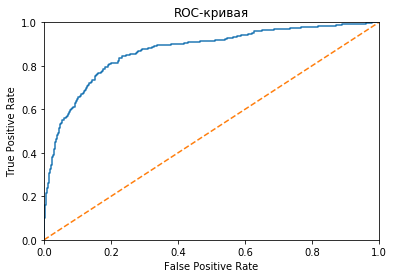

In [37]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

print('roc_auc_score =',roc_auc_score(target_test, probabilities_one_test))

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

По графику мы видим, что наша модель работает значительно лучше чем простое угадывание.

Возьмем ту же модель с балансом классов через взвешивание, наша модель уже прошла проверку по valid, осталось соединить train + valid, обучить на них модель и проверить на этих признаках метрики модели с лучшими гиперпараметрами

In [38]:
features_train2 = pd.concat([features_train, features_valid], ignore_index=True)
target_train2 = pd.concat([target_train, target_valid], ignore_index=True)

In [39]:
%%time

best_accuracy = 0
best_f1_score = 0
best_threshold = 0
threshold = 0.5

model = RandomForestClassifier(random_state=12345, n_estimators=45, max_depth=8,
                               class_weight='balanced')# создаем пустую модель с заданным количеством деревьев
model.fit(features_train2, target_train2) # обучаем модель
    
probabilities_test = model.predict_proba(features_test) # создадим таблицу вероятностей классов
probabilities_one_test = probabilities_test[:, 1] # выделим вероятности 1 класса
predicted_test = probabilities_one_test > threshold # переведем предикт в булев массив сравнив вероятности единицы и порог
f1 = f1_score(target_test, predicted_test) # сохраняем наилучший f1_score
accuracy = accuracy_score(target_test, predicted_test) #  сохраняем наилучшее значение метрики accuracy на валидационных данных

print("Наилучшие гипермараметры модели: Порог = {:.2f} | Accuracy = {:.3f}, F1_score = {:.3f}"
      .format(threshold, accuracy, f1)
)

Наилучшие гипермараметры модели: Порог = 0.50 | Accuracy = 0.832, F1_score = 0.640
CPU times: user 304 ms, sys: 6.53 ms, total: 310 ms
Wall time: 312 ms
